# Segmentation Prelim Experiments 

Generalized Procrustes Analysis on point clouds extracted using code from 7.27 Segmentation Experiments

## General Imports

In [1]:
import numpy as np
import os 

from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes

from pycpd import DeformableRegistration, RigidRegistration

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

%matplotlib notebook


## Define some utilities, paths

In [2]:
save_path = "/Users/Alex/Documents/TaylorLab/segmentation_raw/"

In [3]:
segmentation_list = [
("/Users/Alex/Downloads/IR_134/Segmentation RT 134/Segmentation RT 134.seg.nrrd", "Segmentation RT 134"),
("/Users/Alex/Downloads/IR_134/Segmentation LT 134/Segmentation LT 134.seg.nrrd", "Segmentation LT 134"),
("/Users/Alex/Downloads/IR_138/Segmentation RT 138/Segmentation RT 138.seg.nrrd", "Segmentation RT 138"),
("/Users/Alex/Downloads/IR_138/Segmentation LT 138/Segmentation LT 138.seg.nrrd", "Segmentation LT 138"),
("/Users/Alex/Downloads/IR_140/Segmentation RT 140/Segmentation RT 140.seg.nrrd", "Segmentation RT 140"),
("/Users/Alex/Downloads/IR_140/Segmentation LT 140/Segmentation LT 140.seg.nrrd", "Segmentation LT 140"),
("/Users/Alex/Downloads/IR_144/Segmentation RT 144/Segmentation RT 144.seg.nrrd", "Segmentation RT 144"),
("/Users/Alex/Downloads/IR_144/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 144"),
("/Users/Alex/Downloads/IR_146/Segmentation RT 146/Segmentation RT 146.seg.nrrd", "Segmentation RT 146"),
("/Users/Alex/Downloads/IR_146/Segmentation LT 146/Segmentation LT 146.seg.nrrd", "Segmentation LT 146"),
("/Users/Alex/Downloads/IR_148/Segmentation LT 148/Segmentation LT 148.seg.nrrd", "Segmentation LT 148"),
("/Users/Alex/Downloads/IR_150/Segmentation RT 150/Segmentation RT 150.seg.nrrd", "Segmentation RT 150"),
("/Users/Alex/Downloads/IR_150/Segmentation LT 150/Segmentation LT 150.seg.nrrd", "Segmentation LT 150"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation RT lly/Segmentation RT 144.seg.nrrd", "Segmentation RT 147"),
("/Users/Alex/Downloads/IR_144\ but\ not\ actually/Segmentation LT 144/Segmentation LT 144.seg.nrrd", "Segmentation LT 147"),
]

### First, use Rigid CPD to map source points to an initial shape. 
The highest likelihood corresponding points from each shape will be used to produce the mean shape 


In [6]:
n_target= 500
n_source = 800
keep_id = 4

# prepare the source point cloud
seg_path, identifier = segmentation_list[0]
identifier = identifier.replace(" ", "")
target_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
indices = np.random.randint(0, target_cloud.shape[0]-1, size=n_target)
target_cloud = target_cloud - np.mean(target_cloud, axis=0)
target_cloud = target_cloud[indices]

# data structures for storing transformations, correspondences
ss = []
Rs = []
ts = []
Ps = []
corresponded_sources = []
disparities = []
transformed_sources = []

# iterate over the target point clouds
for seg_path, identifier in segmentation_list[1:]:
    print(identifier)
    identifier = identifier.replace(" ", "")

    source_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices_source = np.random.randint(0, source_cloud.shape[0]-1, size=n_source)
    source_cloud = source_cloud - np.mean(source_cloud, axis=0)
    if "LT" in identifier: 
        source_cloud[:,0] = -1.*source_cloud[:,0]

    source_cloud = source_cloud[indices_source]

    reg = RigidRegistration(**{'X': target_cloud, 'Y': source_cloud})
    reg.register()
    s, R, t = reg.get_registration_parameters()
    P = reg.P

    ss.append(s)
    Rs.append(R)
    ts.append(t)
    Ps.append(P)
    
#     print 'the shape of P is', P.shape
    corresponded = source_cloud[np.argmax(P, axis=0), :]
    corresponded_sources.append(corresponded) 

    transformed = s*np.dot(source_cloud, R) + t
    
    transformed = transformed[np.argmax(P, axis=0), :]
#     print 'the dims of the transformed shape are', transformed.shape
    
    transformed_sources.append(transformed)

    disparity = np.sum(np.square(corresponded - transformed))
    disparities.append(disparity)
    


Segmentation LT 134
Segmentation RT 138
Segmentation LT 138
Segmentation RT 140
Segmentation LT 140
Segmentation RT 144
Segmentation LT 144
Segmentation RT 146
Segmentation LT 146
Segmentation LT 148
Segmentation RT 150
Segmentation LT 150
Segmentation RT 147
Segmentation LT 147


In [7]:
transformed_sources.append(target_cloud)
all_initial = np.array(transformed_sources)

mean_shape = np.mean(all_initial, axis=0)
mean_shape.shape


(500, 3)

In [8]:
len(ss)

14

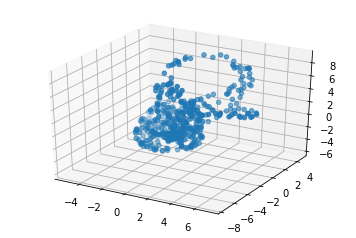

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(mean_shape[:,0], mean_shape[:,1], mean_shape[:,2])

## Deformable Coherent Point Drift 

We use an implementation of Deformable Coherent Point Drift to determine a deformation field that maps a set of source points $Y \in \mathbb{R}^{M \times d}$ to a set of target points $X \in \mathbb{R}^{N \times d}$. This does not have to be initialized with initial correspondences. 

The output that is received are a pair of matrices $G, W$ which determine a deformation $GW$ and a matrix $P$, where entry $P_{m, n} = Prob(Y_m \text{ maps to } X_n)$


### First, we sanity check the s, R, t produced from the rigid CPD 

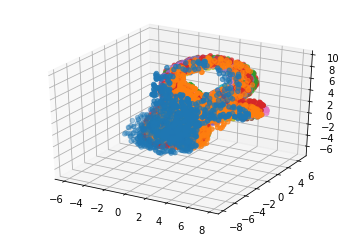

In [10]:
source_cloud = mean_shape
n_target = 1000

# data structures for storing transformations, correspondences
Gs = []
Ws = []
Ps = []
corresponded_targets = []

disparities = []

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# iterate over point clouds, setting each as the target for the mean shape to be deformed to
for i, (seg_path, identifier) in enumerate(segmentation_list):
    identifier = identifier.replace(" ", "")

    target_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices_target = np.random.randint(0, target_cloud.shape[0]-1, size=n_target)
    target_cloud = target_cloud - np.mean(target_cloud, axis=0)
    if "LT" in identifier: 
        target_cloud[:,0] = -1.*target_cloud[:,0]
        
    # access the rough rotation, scale, translations from the rigid CPD previously executed
    R = Rs[i-1]
    s = ss[i-1]
    t = ss[i-1]
    
    if i == 0: 
        R = np.eye(3)
        s = 1.
        t = 0.

    target_cloud = s * np.dot(target_cloud, R) + t
    
    target_cloud = target_cloud[indices_target]

    ax.scatter(target_cloud[:, 0], target_cloud[:, 1], target_cloud[:, 2])
    

### Next, Deformable CPD will be used to map each shape to the mean shape. 

This will produce a deformation field through which we can define the statistical shape model. 

In [11]:
# n_source= 500
# n_target = 3000

# # prepare the source point cloud
# seg_path, identifier = segmentation_list[0]
# identifier = identifier.replace(" ", "")
# source_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
# indices = np.random.randint(0, source_cloud.shape[0]-1, size=n_source)
# source_cloud = source_cloud - np.mean(source_cloud, axis=0)
# source_cloud = source_cloud[indices]

n_target = 1000
source_cloud = mean_shape

# data structures for storing transformations, correspondences
Gs = []
Ws = []
Ps = []
corresponded_targets = []

disparities = []

# iterate over point clouds, setting each as the target for the mean shape to be deformed to
for i, (seg_path, identifier) in enumerate(segmentation_list):
    identifier = identifier.replace(" ", "")

    target_cloud = np.load(save_path + identifier + "_" + str(keep_id) + ".npy")
    indices_target = np.random.randint(0, target_cloud.shape[0]-1, size=n_target)
    target_cloud = target_cloud - np.mean(target_cloud, axis=0)
    if "LT" in identifier: 
        target_cloud[:,0] = -1.*target_cloud[:,0]
        
    # access the rough rotation, scale, translations from the rigid CPD previously executed
    R = Rs[i-1]
    s = ss[i-1]
    t = ss[i-1]
    
    if i == 0: 
        R = np.eye(3)
        s = 1.
        t = 0.

    target_cloud = s * np.dot(target_cloud, R) + t
    
    target_cloud = target_cloud[indices_target]
   

    reg = DeformableRegistration(**{'X': target_cloud, 'Y': source_cloud})
    reg.register()
    G, W = reg.get_registration_parameters()
    P = reg.P

    Gs.append(G)
    Ws.append(W)
    Ps.append(P)

    corresponded = target_cloud[np.argmax(P, axis=1), :]
    corresponded_targets.append(corresponded) 

    transformed = source_cloud + np.dot(G, W)
    print transformed.shape

    disparity = np.sum(np.square(corresponded - transformed))
    disparities.append(disparity)

(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)
(500, 3)


In [12]:
print ss

[1.0293420258557715, 1.0668764512582474, 1.0584662026250466, 0.9415055827344506, 0.9440187601234697, 1.0572377247711693, 0.9484126608604587, 1.0175578066765265, 1.0220848851285669, 1.0192263369379662, 1.0530581145012188, 1.0422617045847562, 0.9624322542607291, 0.9507291490064249]


### Example of deformable registration result

(500, 3)
91.58125107360898


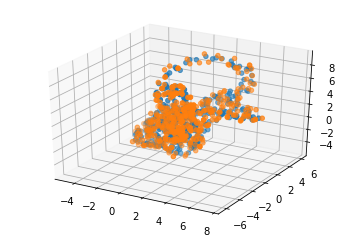

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vis_idx = 1
# target_cloud = corresponded_targets[vis_idx]
# ax.scatter(target_cloud[:,0], target_cloud[:,1], target_cloud[:,2])

transformed = source_cloud + np.dot(Gs[vis_idx], Ws[vis_idx])
ax.scatter(transformed[:,0], transformed[:,1], transformed[:,2])

print(corresponded.shape)
corresponded = corresponded_targets[vis_idx]
ax.scatter(corresponded[:,0], corresponded[:,1], corresponded[:,2])

print(np.sum(np.square(corresponded - transformed)))

### Plot pairs of correspondences for sanity check

Confirms that the correspondences derived from the GMM in the CPD implementation seem right

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# target_cloud = corresponded_targets[0]
# ax.scatter(target_cloud[:,0], target_cloud[:,1], target_cloud[:,2])

transformed = source_cloud + np.dot(Gs[0], Ws[0])
ax.scatter(transformed[:,0], transformed[:,1], transformed[:,2])

print(corresponded.shape)
corresponded = corresponded_targets[0]
ax.scatter(corresponded[:,0], corresponded[:,1], corresponded[:,2])

for point1, point2 in zip(transformed, corresponded): 
    xs = [point1[0], point2[0]]
    ys = [point1[1], point2[1]]
    zs = [point1[2], point2[2]]

    line = plt3d.art3d.Line3D(xs, ys, zs)
    ax.add_line(line)

In [ ]:
deformations = np.array([np.dot(G, W) for G, W in zip(Gs, Ws)])
nshape, npoint, nd = deformations.shape
deformations = deformations.reshape((nshape, npoint*nd), order="F")
u, s, vh = np.linalg.svd(deformations, full_matrices=False)
u.shape, s.shape, vh.shape

## Variance by Principal Component

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(s)), np.square(s)/np.sum(np.square(s)))
ax.set_xlabel("Principal Component Number")
ax.set_ylabel("Percentage of Variance Explained")
ax.set_title("Variance Explained by Each PC")

## Low Rank Approximation of Deformation Fields

We have $$X = USV^T$$

Rank-$k$ approximation determined by $$X \approx U_k S_k V_k^T$$

In [ ]:
k = 2
approx = np.matmul(np.matmul(u[:,:k], np.diag(s[:k])), vh[:k,:])
print approx.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for view in range(14): 
    rough = approx[view].reshape((approx.shape[-1]/3, 3), order="F")
    rough += source_cloud
    ax.scatter(rough[:,0], rough[:,1], rough[:,2])

# ax.scatter(source_cloud[:,0], source_cloud[:,1], source_cloud[:,2])



We can see that low rank approximations of the deformation + initial mean shape recapitulate the unaligned shapes that were directly extracted from Slicer. (Expected) 

## Visualization of Principal Components of the Deformation Field

In [ ]:
pc_idx = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pc = vh[pc_idx,:]
pc = pc.reshape((vh.shape[-1]/3, 3), order="F")
ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2])


ax.set_title("Principal Component #%d"%pc_idx)

## $L_2$ Disparity 

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(disparities)
plt.show()

In [ ]:
plt.close('all')